# **Middle-Fusion**<br/>
**Master's Degree in Data Science (A.Y. 2023/2024)**<br/>
**University of Milano - Bicocca**<br/>

Valentina Barbera, Vittorio Haardt, Luca Porcelli, Luca Sinanaj

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Progetto/Data.zip" -d Data

Streaming output truncated to the last 5000 lines.
  inflating: Data/Data/TCGA-CS-6188/flair_78.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_79.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_82.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_83.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_85.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_89.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_92.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_94.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_57.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_58.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_63.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_65.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_67.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_68.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_73.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_75.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_78.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_79.nii.gz  
  infla

In [ ]:
#!unzip "/content/drive/MyDrive/Medical Imaging & Big Data/Progetto/Data.zip" -d Data

# Installing packages and loading libraries

In [3]:
from torch.utils.data import DataLoader
import torch
import sys
#sys.path.append('/content/drive/MyDrive/Medical Imaging & Big Data/Progetto')
sys.path.append('/content/drive/MyDrive/Progetto')
from dataset import BraTS
import numpy as np
import random
from glob import glob
import torchvision.transforms as transforms
from unet_model_MF import UNet
from torch.nn import functional as F
from tqdm import tqdm

import os
import logging
from time import time
from os.path import dirname as up
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, jaccard_score
import matplotlib.pyplot as plt

# Seed

In [4]:
def seed_all(seed):
    # Pytorch Reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    # DataLoader Workers Reproducibility
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Data

### Reproducibility

In [5]:
seed_all(0)
g=torch.Generator()
g.manual_seed(0)

### Construct Data loader

In [6]:
dataset_train = BraTS("/content/Data/Data", 'train')
dataset_val = BraTS("/content/Data/Data", 'val')
dataset_test = BraTS("/content/Data/Data", 'test')

Loading test data: 100%|██████████| 50/50 [00:12<00:00,  4.16it/s]


In [ ]:
train_loader = DataLoader(dataset_train,
                          batch_size = 5,
                          shuffle = True,
                          num_workers = 0,           # 0 is the main process
                          pin_memory = False,        # Use pinned memory or not
                          persistent_workers= False, # This allows to maintain the workers Dataset instances alive.
                          worker_init_fn=seed_worker,
                          generator=g,
                          drop_last=True)

In [ ]:
val_loader = DataLoader(dataset_val,
                          batch_size = 5,
                          shuffle = False,
                          num_workers = 0,           # 0 is the main process
                          pin_memory = False,        # Use pinned memory or not
                          persistent_workers= False, # This allows to maintain the workers Dataset instances alive.
                          worker_init_fn=seed_worker,
                          generator=g)

In [7]:
test_loader = DataLoader(dataset_test,
                          batch_size = 1,
                          shuffle = False)

# GPU presence check

In [8]:
# Use gpu or cpu
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# 1 is the number of input band and 4 are the classes including the background
model = UNet(1, 4)

model.to(device)

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32

# Training

### Cross Entropy Loss & adam optimizer

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

### Learning Rate scheduler

In [ ]:
reduce_lr_on_plateau=0
if reduce_lr_on_plateau==1:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
else:
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, '[45,65]', gamma=0.1)

### Start training

In [ ]:
epochs = 100
eval_every = 1

In [ ]:
# Train
model.train()

train_losses = []  # List to record training losses
val_losses = []    # List to record validation losses

for epoch in tqdm(range(1, epochs + 1)):
    training_loss = []
    training_batches = 0
    for it, (image, target) in enumerate(train_loader):

        image = image.to(device)
        target = target.to(device).long()

        optimizer.zero_grad()  # Resets gradients
        logits2 = F.upsample(input=model(image[:, 0, :, :].unsqueeze(1), image[:, 1, :, :].unsqueeze(1), image[:, 2, :, :].unsqueeze(1), image[:, 3, :, :].unsqueeze(1)), size=image.size()[2:4], mode='bilinear')
        loss = criterion(logits2, target)  # Computes the loss function

        loss.backward()  # Computes gradients
        training_batches += target.shape[0]  # Updates the count of training batches
        training_loss.append((loss.data * target.shape[0]).tolist())  # Records the loss multiplied by the number of elements in the current batch
        torch.nn.utils.clip_grad_norm_(model.parameters(), float('inf'))  # Applies gradient clipping
        optimizer.step()  # Updates model weights using the optimizer

    print("Training loss was: " + str(sum(training_loss) / training_batches))  # Prints the average training loss per epoch
    train_losses.append(sum(training_loss) / training_batches)  # Records the average training loss per epoch in the list

    # Saves the model
    model_dir = os.path.join(os.path.join(up(os.path.abspath("/content/drive/MyDrive/Progetto/results")), 'trained_models_MF'), str(epoch))
    os.makedirs(model_dir, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(model_dir, 'model.pth'))

    if epoch % eval_every == 0 or epoch == 1:  # Evaluates the model on validation data
        model.eval()
        val_loss = []
        val_batches = 0
        y_true_val = []
        y_predicted_val = []
        seed_all(0)
        with torch.no_grad():
            for (image, target) in val_loader:

                image = image.to(device)
                target = target.to(device).long()

                logits = model(image[:, 0, :, :].unsqueeze(1), image[:, 1, :, :].unsqueeze(1), image[:, 2, :, :].unsqueeze(1), image[:, 3, :, :].unsqueeze(1)) # Runs the model
                logits = F.upsample(input=logits, size=(target.shape[-2], target.shape[-1]), mode='bilinear') # Bilinear upsampling of logits
                loss = criterion(logits, target)  # Computes the loss function

                logits = torch.movedim(logits, (0, 1, 2, 3), (0, 3, 1, 2))  # Moves dimensions to compute probabilities
                logits = logits.reshape((-1, 4))  # Reshapes logits
                target = target.reshape(-1)  # Reshapes targets
                mask = target != 0  # Creates a mask for non-empty targets

                logits = logits[mask]
                target = target[mask]

                probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()  # Computes probabilities
                target = target.cpu().numpy()
                val_batches += target.shape[0]  # Updates the count of validation batches
                val_loss.append((loss.data * target.shape[0]).tolist())  # Records the loss multiplied by the number of elements in the current batch
                y_predicted_val += probs.argmax(1).tolist()  # Adds predictions to the list
                y_true_val += target.tolist()  # Adds true targets to the list

            y_predicted_val = np.asarray(y_predicted_val)
            y_true_val = np.asarray(y_true_val)
            subset_acc = accuracy_score(y_true_val, y_predicted_val)  # Computes accuracy
            print("Acc" + str(subset_acc))  # Prints accuracy

        val_losses.append(sum(val_loss) / val_batches)  # Records the average validation loss per epoch in the list
        scheduler.step()  # Updates the scheduler
        model.train()  # Restores the model to training mode

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 1.245297889158614


  1%|          | 1/100 [01:06<1:50:06, 66.73s/it]

Acc0.0


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 1.1746467087673367


  2%|▏         | 2/100 [02:13<1:49:27, 67.01s/it]

Acc0.0


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 1.099235419676192


  3%|▎         | 3/100 [03:20<1:48:15, 66.96s/it]

Acc0.014202084054983946


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 1.0318034805545737


  4%|▍         | 4/100 [04:28<1:47:20, 67.08s/it]

Acc0.180451381120497


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.9733423804548242


  5%|▌         | 5/100 [05:35<1:46:09, 67.05s/it]

Acc0.07192520690676864


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.9220018617512947


  6%|▌         | 6/100 [06:42<1:45:06, 67.09s/it]

Acc0.15575732498766895


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.8856481056351093


  7%|▋         | 7/100 [07:49<1:44:02, 67.13s/it]

Acc0.10289751539113391


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.8588744662728981


  8%|▊         | 8/100 [08:56<1:42:55, 67.12s/it]

Acc0.02838948314987211


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.8395763521160029


  9%|▉         | 9/100 [10:03<1:41:48, 67.13s/it]

Acc0.19328949152893757


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.8241463227392534


 10%|█         | 10/100 [11:10<1:40:33, 67.04s/it]

Acc0.22749249123437457


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.812718538773189


 11%|█         | 11/100 [12:17<1:39:18, 66.95s/it]

Acc0.15383359521512172


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.8037519300027014


 12%|█▏        | 12/100 [13:24<1:38:14, 66.98s/it]

Acc0.20231728670311416


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7966727830012352


 13%|█▎        | 13/100 [14:31<1:37:01, 66.91s/it]

Acc0.1274326284264547


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7909220001757791


 14%|█▍        | 14/100 [15:38<1:36:09, 67.09s/it]

Acc0.20709767312488175


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.786512909555263


 15%|█▌        | 15/100 [16:45<1:34:56, 67.02s/it]

Acc0.28014671138956865


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7822515343070461


 16%|█▌        | 16/100 [17:52<1:33:52, 67.05s/it]

Acc0.26447267604027824


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.778738337561542


 17%|█▋        | 17/100 [18:59<1:32:42, 67.02s/it]

Acc0.29775225090204527


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7770507874471616


 18%|█▊        | 18/100 [20:06<1:31:29, 66.95s/it]

Acc0.36560022182927954


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7739257301234166


 19%|█▉        | 19/100 [21:13<1:30:37, 67.13s/it]

Acc0.40960327284569475


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7720145123960309


 20%|██        | 20/100 [22:20<1:29:26, 67.08s/it]

Acc0.25859523671723766


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7692436101204222


 21%|██        | 21/100 [23:27<1:28:17, 67.06s/it]

Acc0.3773965638921018


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7678376135843326


 22%|██▏       | 22/100 [24:35<1:27:15, 67.12s/it]

Acc0.4517119640097543


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7659117061738934


 23%|██▎       | 23/100 [25:42<1:26:05, 67.08s/it]

Acc0.4020880285613836


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7657251079159954


 24%|██▍       | 24/100 [26:49<1:24:58, 67.08s/it]

Acc0.48684702677068226


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7639090661968135


 25%|██▌       | 25/100 [27:55<1:23:44, 66.99s/it]

Acc0.41785017367124866


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7624771381543431


 26%|██▌       | 26/100 [29:02<1:22:33, 66.94s/it]

Acc0.5241874250095236


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7611474736072527


 27%|██▋       | 27/100 [30:09<1:21:20, 66.85s/it]

Acc0.5083078002188923


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7610184941481167


 28%|██▊       | 28/100 [31:16<1:20:11, 66.83s/it]

Acc0.5360520089457321


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7602585921649038


 29%|██▉       | 29/100 [32:22<1:18:59, 66.76s/it]

Acc0.514136001734553


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7599049015596024


 30%|███       | 30/100 [33:29<1:17:56, 66.80s/it]

Acc0.3763383829440235


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7583326857873248


 31%|███       | 31/100 [34:36<1:16:49, 66.80s/it]

Acc0.4863434190215152


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7578030866836383


 32%|███▏      | 32/100 [35:43<1:15:46, 66.86s/it]

Acc0.3595517459121822


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7578825651093081


 33%|███▎      | 33/100 [36:50<1:14:41, 66.89s/it]

Acc0.3965561177111848


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7572272219812827


 34%|███▍      | 34/100 [37:57<1:13:33, 66.87s/it]

Acc0.3935171947925404


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7564088978061607


 35%|███▌      | 35/100 [39:04<1:12:30, 66.93s/it]

Acc0.5104690808165183


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7560085034972924


 36%|███▌      | 36/100 [40:11<1:11:27, 67.00s/it]

Acc0.5868766558372285


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7555178757609012


 37%|███▋      | 37/100 [41:18<1:10:21, 67.01s/it]

Acc0.4873359495597535


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7553412100037943


 38%|███▊      | 38/100 [42:25<1:09:14, 67.01s/it]

Acc0.5320646103691367


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7550048812632096


 39%|███▉      | 39/100 [43:32<1:08:07, 67.00s/it]

Acc0.4389524613288852


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.754956989081758


 40%|████      | 40/100 [44:39<1:06:57, 66.95s/it]

Acc0.5892513002668344


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7543871473319264


 41%|████      | 41/100 [45:46<1:05:47, 66.91s/it]

Acc0.4345314245188732


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7543647387397848


 42%|████▏     | 42/100 [46:53<1:04:42, 66.95s/it]

Acc0.5709201509613898


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7545291401418969


 43%|████▎     | 43/100 [48:00<1:03:36, 66.96s/it]

Acc0.5105079527697131


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7536944375571791


 44%|████▍     | 44/100 [49:07<1:02:35, 67.06s/it]

Acc0.555407650173153


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7541106728440158


 45%|████▌     | 45/100 [50:14<1:01:29, 67.09s/it]

Acc0.4772059185572113


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7535289745468525


 46%|████▌     | 46/100 [51:22<1:00:28, 67.20s/it]

Acc0.45597924064935164


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7533697479468391


 47%|████▋     | 47/100 [52:29<59:19, 67.17s/it]  

Acc0.5527393065416314


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7530196856075245


 48%|████▊     | 48/100 [53:36<58:12, 67.16s/it]

Acc0.5256844271181111


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7529913148294718


 49%|████▉     | 49/100 [54:43<57:06, 67.19s/it]

Acc0.51807070721904


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7527235335821709


 50%|█████     | 50/100 [55:50<55:55, 67.11s/it]

Acc0.5085894059242584


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7525428730658246


 51%|█████     | 51/100 [56:57<54:47, 67.10s/it]

Acc0.3705879253347523


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7529952961615277


 52%|█████▏    | 52/100 [58:04<53:34, 66.96s/it]

Acc0.48943676267463226


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7519727953074211


 53%|█████▎    | 53/100 [59:11<52:25, 66.93s/it]

Acc0.5121518044792583


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7520526772371698


 54%|█████▍    | 54/100 [1:00:18<51:25, 67.07s/it]

Acc0.57930094407017


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7519519638929126


 55%|█████▌    | 55/100 [1:01:25<50:16, 67.04s/it]

Acc0.4066170430191587


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7511616080246247


 56%|█████▌    | 56/100 [1:02:32<49:12, 67.11s/it]

Acc0.5689186772824532


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7507504702475096


 57%|█████▋    | 57/100 [1:03:39<48:06, 67.13s/it]

Acc0.6358959164581258


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7507236396362635


 58%|█████▊    | 58/100 [1:04:47<47:04, 67.24s/it]

Acc0.5998503861712594


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7505676231659707


 59%|█████▉    | 59/100 [1:05:54<45:54, 67.17s/it]

Acc0.6103915960564835


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7505433258166813


 60%|██████    | 60/100 [1:07:01<44:45, 67.14s/it]

Acc0.5870995217022115


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7506127354040043


 61%|██████    | 61/100 [1:08:08<43:40, 67.20s/it]

Acc0.5295906265035888


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.750275942392728


 62%|██████▏   | 62/100 [1:09:15<42:30, 67.12s/it]

Acc0.671849017878507


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7503604224442575


 63%|██████▎   | 63/100 [1:10:23<41:30, 67.30s/it]

Acc0.47703229049960827


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7508661011926534


 64%|██████▍   | 64/100 [1:11:30<40:23, 67.33s/it]

Acc0.6422355001135925


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7501944998111105


 65%|██████▌   | 65/100 [1:12:38<39:21, 67.47s/it]

Acc0.5737785352529744


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7500968413232466


 66%|██████▌   | 66/100 [1:13:46<38:14, 67.49s/it]

Acc0.49640693579303535


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7503010859988657


 67%|██████▋   | 67/100 [1:14:53<37:08, 67.54s/it]

Acc0.6015771647142868


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7505591865911381


 68%|██████▊   | 68/100 [1:16:01<36:04, 67.63s/it]

Acc0.49352954743544447


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7496779502083678


 69%|██████▉   | 69/100 [1:17:08<34:51, 67.48s/it]

Acc0.6023641058111843


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7494998446440438


 70%|███████   | 70/100 [1:18:16<33:43, 67.45s/it]

Acc0.6029618700692008


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7495691399281637


 71%|███████   | 71/100 [1:19:23<32:35, 67.42s/it]

Acc0.5248111039030032


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7494814650676741


 72%|███████▏  | 72/100 [1:20:31<31:27, 67.42s/it]

Acc0.6252570947793239


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7494754510666058


 73%|███████▎  | 73/100 [1:21:37<30:13, 67.16s/it]

Acc0.5748548564458769


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7494577734909333


 74%|███████▍  | 74/100 [1:22:44<29:02, 67.03s/it]

Acc0.5453968264937412


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.749821168851336


 75%|███████▌  | 75/100 [1:23:50<27:51, 66.87s/it]

Acc0.5805569400689502


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7492921180243096


 76%|███████▌  | 76/100 [1:24:57<26:42, 66.76s/it]

Acc0.6426924615189259


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7497785160257497


 77%|███████▋  | 77/100 [1:26:04<25:37, 66.84s/it]

Acc0.67913103044365


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7493803909108957


 78%|███████▊  | 78/100 [1:27:10<24:29, 66.79s/it]

Acc0.5824556190272164


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7491344797912487


 79%|███████▉  | 79/100 [1:28:18<23:24, 66.87s/it]

Acc0.615641037380134


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7491633430715072


 80%|████████  | 80/100 [1:29:24<22:16, 66.82s/it]

Acc0.5985494714710097


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7491441583805566


 81%|████████  | 81/100 [1:30:31<21:10, 66.88s/it]

Acc0.7168316421154289


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7491165154247077


 82%|████████▏ | 82/100 [1:31:38<20:02, 66.80s/it]

Acc0.681811467571721


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7488390258072946


 83%|████████▎ | 83/100 [1:32:44<18:54, 66.74s/it]

Acc0.6149914438511912


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7488803961647116


 84%|████████▍ | 84/100 [1:33:51<17:47, 66.70s/it]

Acc0.5782194399501748


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.748708655429661


 85%|████████▌ | 85/100 [1:34:58<16:40, 66.69s/it]

Acc0.5734831084086945


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7489368624635552


 86%|████████▌ | 86/100 [1:36:05<15:34, 66.74s/it]

Acc0.6282528266388632


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7489914358738097


 87%|████████▋ | 87/100 [1:37:11<14:27, 66.70s/it]

Acc0.534854752787335


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7490184863121501


 88%|████████▊ | 88/100 [1:38:18<13:21, 66.79s/it]

Acc0.686893327586043


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7491846650946442


 89%|████████▉ | 89/100 [1:39:25<12:14, 66.76s/it]

Acc0.6011176118454071


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.748814804373235


 90%|█████████ | 90/100 [1:40:32<11:08, 66.80s/it]

Acc0.675667971324592


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.74883893181701


 91%|█████████ | 91/100 [1:41:38<10:00, 66.75s/it]

Acc0.5929864630582552


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7491228258566736


 92%|█████████▏| 92/100 [1:42:45<08:53, 66.70s/it]

Acc0.7228161952650506


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7500938770142703


 93%|█████████▎| 93/100 [1:43:52<07:46, 66.70s/it]

Acc0.6939066917635515


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7488300745237605


 94%|█████████▍| 94/100 [1:44:58<06:39, 66.63s/it]

Acc0.6903382464602767


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7484419318312773


 95%|█████████▌| 95/100 [1:46:05<05:33, 66.65s/it]

Acc0.5710721834894402


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7483094845437831


 96%|█████████▌| 96/100 [1:47:11<04:26, 66.59s/it]

Acc0.5496053632929555


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7487436635399554


 97%|█████████▋| 97/100 [1:48:18<03:19, 66.61s/it]

Acc0.724213857937696


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7484977042201624


 98%|█████████▊| 98/100 [1:49:24<02:13, 66.55s/it]

Acc0.7356378930710311


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7482398487600609


 99%|█████████▉| 99/100 [1:50:31<01:06, 66.56s/it]

Acc0.674562280211498


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7485468797305


100%|██████████| 100/100 [1:51:37<00:00, 66.98s/it]

Acc0.6311647678437382


### Loss visualization for epochs

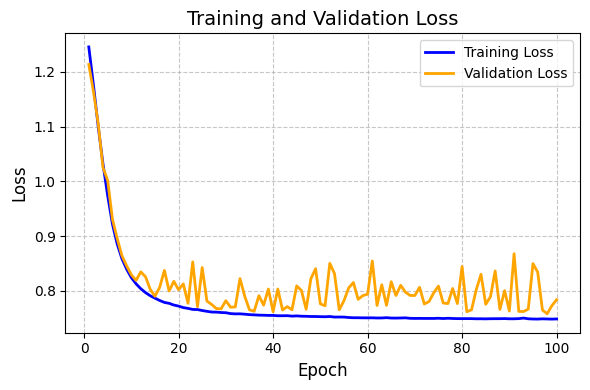

In [ ]:
plt.figure(figsize=(6, 4))

epochs = len(train_losses)

plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='orange', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

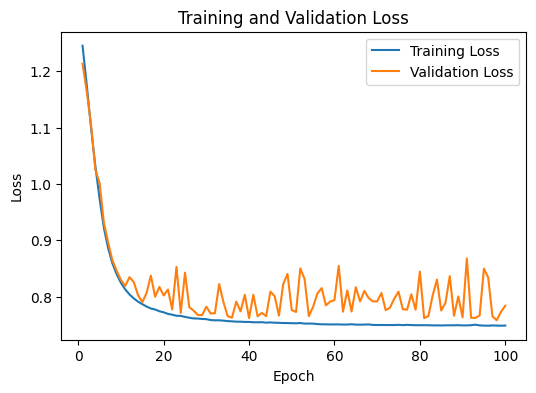

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Test

### Loading model

In [9]:
models_list = []
models_files = glob(os.path.join(os.path.join("/content/drive/MyDrive/Progetto/trained_models_MF/", '100'),'*.pth'))

for model_file in models_files:

    model = UNet(1, 4)

    model.to(device)

    # Load model from specific epoch to continue the training or start the evaluation
    checkpoint = torch.load(model_file, map_location = device)
    checkpoint = {k.replace('decoder','decode_head'):v for k,v in checkpoint.items() if ('proj1' not in k) and ('proj2' not in k)}

    # Modify keys in the loaded checkpoint dictionary to match the model's expected keys
    checkpoint = {k.replace('decode_head', 'decoder'): v for k, v in checkpoint.items()}

    # Load the modified state dictionary into the model
    model.load_state_dict(checkpoint)

    del checkpoint  # dereference
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model.eval()

    models_list.append(model)

### Evaluation

In [10]:
a=[]
b=[]
inputs_list = []
y_true = []
y_predicted = []

In [11]:
def dice_coefficient_multiclass(y_true, y_pred, num_classes):
    dice_scores = []
    for class_label in range(1, num_classes):
        y_true_class = [1 if x == class_label else 0 for x in y_true]
        y_pred_class = [1 if x == class_label else 0 for x in y_pred]
        intersection = sum(y_true_class[i] * y_pred_class[i] for i in range(len(y_true)))
        union = sum(y_true_class) + sum(y_pred_class)
        dice = (2. * intersection) / (union)
        dice_scores.append(dice)
    return dice_scores

In [12]:
with torch.no_grad():
    for (image, target) in tqdm(test_loader, desc="testing"):
        image = image.to(device)
        target = target.to(device)
        seed_all(0)

        all_predictions = []
        logits = model(image[:, 0, :, :].unsqueeze(1), image[:, 1, :, :].unsqueeze(1), image[:, 2, :, :].unsqueeze(1), image[:, 3, :, :].unsqueeze(1))

        im_input = (image[0].detach().cpu().numpy())  # Convert the first image to a numpy array and detach from the computation graph
        inputs_list.append(im_input)  # Append the input image to a list (for visualization)

        # Accuracy metrics only on annotated pixels
        probs = torch.nn.functional.softmax(logits, dim=1)  # Compute softmax probabilities from logits
        predictions = probs.argmax(1)  # Get the class predictions by selecting the index of the maximum probability
        predictions = predictions.reshape(-1)  # Reshape predictions to a 1D array

        a.append(target.cpu().numpy())
        b.append(predictions.cpu().numpy())

        target = target.reshape(-1)  # Reshape true targets to a 1D array
        mask = target != 0  # Create a mask for non-zero targets
        predictions = predictions[mask].cpu().numpy()  # Apply the mask to predictions and convert to numpy array
        target = target[mask]  # Apply the mask to true targets
        target = target.cpu().numpy()  # Convert true targets to numpy array
        y_predicted += predictions.tolist()  # Add predictions to the list 'y_predicted'
        y_true += target.tolist()  # Add true targets to the list 'y_true'

    # Calculate and print scores
    subset_acc = accuracy_score(y_true, y_predicted)  # Compute subset accuracy
    iou_acc = jaccard_score(y_true, y_predicted, average='macro')  # Compute IoU
    dice_coeff = dice_coefficient_multiclass(y_true, y_predicted, 4)  # Compute Dice coefficient
    print("accuracy_score: " + str(subset_acc))
    print("IoU: " + str(iou_acc))
    print("Dice coefficient: class1: " + str(dice_coeff[0]) + " class2: " + str(dice_coeff[1]) + " class3: " + str(dice_coeff[2]))

testing: 100%|██████████| 827/827 [00:12<00:00, 65.26it/s]


accuracy_score: 0.6138263879561158
IoU: 0.372848227445841
Dice coefficient: class1: 0.6867415141788911 class2: 0.6772061501342923 class3: 0.6268565726900152


### Visual evaluation

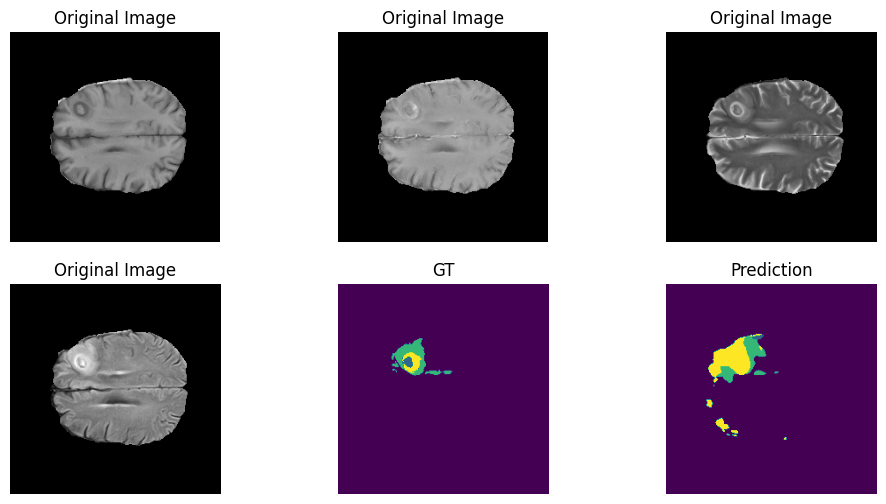

In [36]:
n = 150

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes[0, 0].imshow(inputs_list[n][0,:,:], cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')
axes[0, 1].imshow(inputs_list[n][1,:,:], cmap='gray')
axes[0, 1].set_title('Original Image')
axes[0, 1].axis('off')
axes[0, 2].imshow(inputs_list[n][2,:,:], cmap='gray')
axes[0, 2].set_title('Original Image')
axes[0, 2].axis('off')
axes[1, 0].imshow(inputs_list[n][3,:,:], cmap='gray')
axes[1, 0].set_title('Original Image')
axes[1, 0].axis('off')


axes[1, 1].imshow(np.resize(a[n], (240, 240)))
axes[1, 1].set_title('GT')
axes[1, 1].axis('off')
axes[1, 2].imshow(np.resize(b[n], (240, 240)))
axes[1, 2].set_title('Prediction')
axes[1, 2].axis('off')
plt.show()